It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning/blob/main/class/Fundamentals/NN_Fundamentals.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning/blob/main/class/Fundamentals/NN_Fundamentals.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

In [1]:
import tensorflow as tf  #USAMOS TENSOR FLOW , KERAS QUE ESTA DENTRO DE TENSOR Y SKLEARN
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

# SON FUNCIONES QUE NOS VAN A SERVIR PERO QUE NO HACE FAKTA MIRARLAS

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap=plt.cm.Spectral)
    
def load_planar_dataset(m, sigma=0.2):
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*sigma # theta
        r = a*np.sin(4*t) + np.random.randn(N)*sigma # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    ## premuting ouput
    p = np.random.permutation(m)
    X = X[p,:]
    Y = Y[p,:]

    return X, Y.ravel()

def draw_neural_net(left, right, bottom, top, layer_sizes):
    '''
    From https://gist.github.com/craffel/2d727968c3aaebd10359#file-draw_neural_net-py
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    fig = plt.figure(figsize=(3, 3))
    ax = fig.gca()
    ax.axis('off')

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

## Dataset 

We have a binary classification dataset. The target `y` has two possible values, {0,1} and the input vector `x` has two dimensions.

In [3]:
N = 5000
X, y = load_planar_dataset(N, 0.2)

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data. 

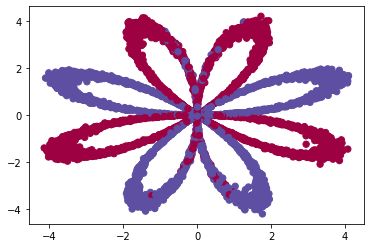

In [4]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

#ES UN DATASET QUE SE LLAMA DE FLORES, ES COMLEJO, TENEMOS LOS DATOS EN UN PLANO Y TENEMOS DOS CLASES (AZUL Y ROJA) POR LO QUE VA A SER UN PROBLEMA DE CLASIFICACION BINARIA

#UNA REGRESION LOGISTICA NUNCA VA A APRENDER COMO SEPARAR NUESTRA DOS CLASES TENDREMOS QUE USAR UN MODELO COMPLEJO


In [5]:
#SEPARAMOS EN TRAIN Y TEST

# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.2,
)


#TENEMOS 2 VARIABLES INDEPENDIENTES (creo) (X) Y LUEGO Y CON DOS CLASES (0 Y 1)

In [6]:
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


In [7]:

#EN EL CASO DE LA X SON LAS COORDENADAS
## X first example
X[0,:]

array([3.3747929 , 1.13883696])

In [8]:
# EN EL CASO DE LA Y SON 0 Y 1

## Y firsts examples
y[:8]

array([1, 1, 0, 0, 1, 0, 1, 1], dtype=uint8)

## First NN in Keras

### Logistic regression

Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class. We can specify the number of neurons as the first argument, and specify the activation function using the activation argument.

```python

#NUESTRAS CAPAS LA VAMOS A DEFINIR CON LA CLASE DENSE
tf.keras.layers.Dense(
    units, activation=None
)


#VAMOS A TENER DOS PARAMETROS

#UNITS: NUMERO DE NEURONA DE NUESTRA CAPA

#ACTIVACION: FUNCION DE ACTIVACION 
```

- **units**: Number of neurons in the layer.
- **activation**: Activation function to use, default function is `linear`, you can also use `sigmoid` for sigmoid activation or [other alternatives](https://www.tensorflow.org/api_docs/python/tf/keras/activations) 

For defining the input layer you can use `keras.Input(shape=(input_dimension,))` or define your input dimension in the first hidden layer.

```python

# EN LA PRIMERA CAPA SOLO TENEMOS QUE PONER LA DIMENSION DE LOS DATOS DE ENTRADA 
layers.Dense(4, activation="sigmoid", input_shape=(input_dimension,))

```

Build a network without hidden layer

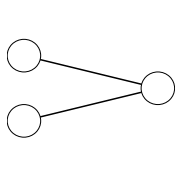

In [9]:
draw_neural_net(.1, .9, .1, .9, [2, 1])

In [10]:
#PRIMERO SE DECLARA EL MODELO VACIO Y LUEGO SE LE VAN AÑADIENDO LAS CAPAS CON MODEL.ADD

# EN ESTE CASO SOLO TENEMOS UNA CAPA DE SALIDA CON UNA NEURONA

model = keras.Sequential()
# The dimension of the input is 2 (planar data)
# we have only one output layer with 1 neuron
model.add(keras.layers.Dense(1, input_shape=(2, ), activation='sigmoid'))


# POR LO TANTO PONEMOS 1 NEURONA , INPUT SHAPE PORQUE ES LA PRIMERA CAPA (SERA 2 PORQUE SON DOS LAS ENTRADAS) Y LA FUNCION DE ACTIVACION SERA SIGMOIDE (CLASIFICACION BINARIA)

In [11]:
#VEMOS LOS PARAMETROS QUE TIENE NUESTRO MODELO 

# SON TRES, EL PESO DE UNA ENTRADA, UNO, EL DE LA OTRA, DOS, Y LA B ,TRES.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


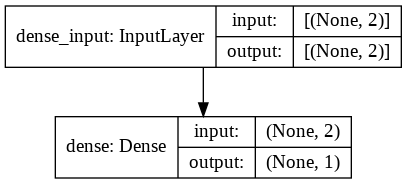

In [12]:
#VEMOS LA FUNCION DIBUJADA

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

#### Compile
Now we need to specify the loss function, the metrics and the optimizer. It is done using compile function in Keras.

In [14]:
#UNA VEZ ESPECIFICADO EL MODELO SE TIENE QUE COMPILAR, LA COMPILACION ES QUE OPTIMIZACION QUIERES USAR , LA FUNCION DE PERDIDA Y LAS METRICAS PARA VALORAR EL MODELO

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### Training model
This is similar to a sklearn model.

In [15]:
#EL TRAININNNGGG

model.fit(X_train, y_train, epochs=10,
          validation_split=0.2, batch_size=32)


#NOS VA DICIENDO LO QUE ESRA HACIEDNO  , NOS DICE EL ACCURACY DEL TRAIN (NO LO QUEREMOS) Y EL DE VALIDATION (ESTE SII)

#ES UN RESULTADO BASTANTE POBRE PARA QUE MENTIR 0.67 , ES UNA REGRESION LOGISTICA , SOLO ES UNA RECTA......... 

Epoch 1/10
100/100 [==============================] - 1s 3ms/step - loss: 1.1101 - accuracy: 0.5806 - val_loss: 1.0676 - val_accuracy: 0.5650
Epoch 2/10
100/100 [==============================] - 0s 1ms/step - loss: 1.0493 - accuracy: 0.5869 - val_loss: 1.0097 - val_accuracy: 0.5675
Epoch 3/10
100/100 [==============================] - 0s 1ms/step - loss: 0.9928 - accuracy: 0.5959 - val_loss: 0.9564 - val_accuracy: 0.5788
Epoch 4/10
100/100 [==============================] - 0s 2ms/step - loss: 0.9400 - accuracy: 0.6034 - val_loss: 0.9067 - val_accuracy: 0.5863
Epoch 5/10
100/100 [==============================] - 0s 1ms/step - loss: 0.8915 - accuracy: 0.6100 - val_loss: 0.8609 - val_accuracy: 0.5962
Epoch 6/10
100/100 [==============================] - 0s 1ms/step - loss: 0.8476 - accuracy: 0.6172 - val_loss: 0.8199 - val_accuracy: 0.6087
Epoch 7/10
100/100 [==============================] - 0s 2ms/step - loss: 0.8087 - accuracy: 0.6288 - val_loss: 0.7846 - val_accuracy: 0.6250
Epoch 

#### Making predictions

In [16]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

#NI LLEGA EL HIJO PUTA A 0.7 PERO BUENO ES UNA REGRESION LOGISTICA...

Test Loss: 0.6795349717140198
Test Accuracy: 0.699999988079071


In [17]:
y_pred = model.predict(X_test)
y_pred[:3], y_test[:3]

(array([[0.8089329 ],
        [0.59683865],
        [0.22263047]], dtype=float32), array([1, 1, 0], dtype=uint8))

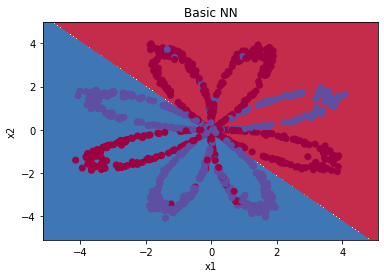

In [18]:
#AL TENER SOLO UNA CAPA SOLO PUEDE APRENDER UNA RECTA, NECESITAMOS UN MODELO ALGO MAS COMPLEJO , COMO HACERLO ? AÑÁDIENDO UNA CAPA OCULTA


plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("Basic NN");

### One hidden layer NN

- One **input with 2 features (input_shape)**
- **One hidden dense layer**,  with **3 neurons** and implemented with  **sigmoid activating function**
- **One Output** (sigmoid output activation function)

We can create layers incrementally with the method `add()`:

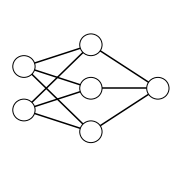

In [19]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 1])

In [20]:
#LO DISEÑAMOS COMO CUALQUIER MODELO, LO DECLARAMOS MODELO VACIO Y VAMOS AÑADIENDO LAS CAPAS


model = keras.Sequential()

## hidden layer with 3 neurons and sigmoid activation
## The first layer need to have the input_shape

# LA PRIMERA CAPA ES UNA CAPA DENSA DE TRES NEURONAS, COMO ES LA PRIMERAA CAPA TENERMOS QUE PONER LA DIMENSION DE LOS DATOS DE ENTRADA Y USAMOS LA FUNCION DE ACTIVACION SIGMOID

model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))

# output layer


#LA ULTIMA CAPA 1 NEURONA CON ACTIVACION SIGMOID
model.add(layers.Dense(1, activation='sigmoid'))

## model summary


#TENDREMOS 9 PESOS ( 3 POR 2 MAS TRES VIAS) Y EL ORTRO TRES POR 1 MAS UNA VIA (4)     ------>  CAPITULO 4 MIN 6:26

# 13 EN TOTAL 
 model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


You can also define the model with a list of layers


SE PUEDE METER TODO EN UNO COMO UNA LISTA
```python
model = keras.Sequential([
    keras.Input(shape=(2, )),
    layers.Dense(3, activation='sigmoid', name='layer1'),
    layers.Dense(1, activation='sigmoid', name='layer3')
])
````

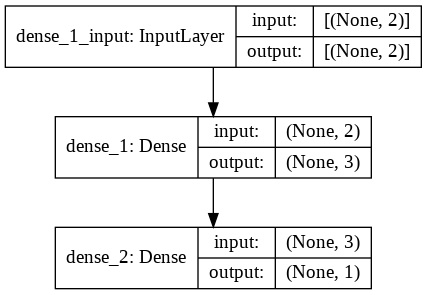

In [21]:
plot_model(model, show_shapes=True)

In [22]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 1s 3ms/step - loss: 0.7253 - accuracy: 0.5094 - val_loss: 0.7262 - val_accuracy: 0.4775
Epoch 2/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6980 - accuracy: 0.5394 - val_loss: 0.7018 - val_accuracy: 0.5650
Epoch 3/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6822 - accuracy: 0.5641 - val_loss: 0.6867 - val_accuracy: 0.5425
Epoch 4/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6731 - accuracy: 0.5528 - val_loss: 0.6772 - val_accuracy: 0.5462
Epoch 5/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6672 - accuracy: 0.5631 - val_loss: 0.6706 - val_accuracy: 0.5550
Epoch 6/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6625 - accuracy: 0.5756 - val_loss: 0.6652 - val_accuracy: 0.5763
Epoch 7/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6581 - accuracy: 0.5953 - val_loss: 0.6603 - val_accuracy: 0.5850
Epoch 

In [23]:
# ES ALGO MEJOR QUE EL ANTERIOR PERO SIGUE AHI AHI SIGUE SIENDO MUY POQUITO 

#ES UNA FUNCION MAS COMPLEJA YA

results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.5869544744491577
Test Accuracy: 0.6420000195503235


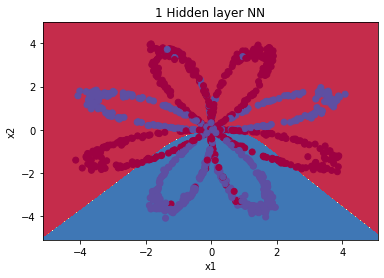

In [24]:
# HA APRENDIDO UNA LIGERA CURVA

plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN");

### Question 1:
####  What happens if we change the activation function of the first hidden  layer to `'linear'`? 

In [ ]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
model.add(layers.Dense(3, input_shape=(2,), activation=...))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

### Question 2:
####  What happens if we add more neurons to the first hidden layer ? 

In [ ]:
draw_neural_net(.1, .9, .1, .9, [2, 5, 1])

In [ ]:
model = keras.Sequential()

## The first layer need to have the input_shape
## set the number of neurons
model.add(layers.Dense(..., input_shape=(2,), activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

### Question 3:
####  What happens if we add one more hidden layer ? 

In [ ]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 3, 1])

In [ ]:
model = keras.Sequential()
# First hidden layer (need to innclude input_shape)
## Set the number of neurons
model.add(layers.Dense(..., input_shape=(2,), activation='sigmoid'))

# second hidden layer
## Complete the code
model.add(...

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

####  Use  the [hyperbolic tangent](https://mathworld.wolfram.com/HyperbolicTangent.html) activation `'tanh'` with the first simple model and compare the results with the sigmoid activation

In [ ]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
model.add(layers.Dense(3, input_shape=(2,), activation=...))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

## Practice I

Repeat the process with a different dataset.

In [ ]:
N = 5000
X, y = sklearn.datasets.make_moons(n_samples=N, noise=.18)

In [ ]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

### Define your model

In [ ]:
model = keras.Sequential()
## The first layer need to have the input_shape
model.add(layers...(..., input_shape=(...,), activation=...))

## Second Layer, don't use input_shape
model...(...)

# output layer
model.add(layers.Dense(..., activation=...))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)

## Functional API

The Keras Functional API allows defining the topology of the models as a [acyclic directed graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph) of layers. Next we will build the same model as in the previous section but using the Keras Functional API.

You need to start with an input data entry:
```python    
    inputs = keras.Input(shape=(8,))
```
    
We define the layers that we will include in the network and the relationships between them. It is important to note that each line details the type of layer and its properties (number of neurons, activation function, name ...) and just at the end, in parentheses, the name of the variable in which we have saved the layer from which its output will connect to the input of the layer we are declaring.
```python
layer_1 = layers.Dense(4, activation='sigmoid',
                       name='layer_1')(inputs)
layer_2 = layers.Dense(4, activation='sigmoid',
                       name='layer_2')(layer_1)
```

The "layer call" `Dense()(inputs)` action is like drawing an arrow from "inputs" to this layer you created. You're "passing" the inputs to the dense layer, and you get `layer_1` as the output.

  

Finally, we define the network outputs:
```python
outputs = layers.Dense(1, name='output_layer')(layer_2)
```

We create the model specifying the inputs and outputs:
```python
model = keras.Model(inputs=inputs, outputs=outputs)
```

In [ ]:
draw_neural_net(.1, .9, .1, .9, [8, 4, 4, 1])

In [ ]:
inputs = keras.Input(shape=(8, ), name='input_layer')
l_1 = layers.Dense(4, activation='relu', name='layer_1')(inputs)
l_2 = layers.Dense(4, activation='relu', name='layer_2')(l_1)
outputs = layers.Dense(1, name='output_layer')(l_2)

model = keras.Model(inputs=inputs, outputs=outputs, name='example_model')

model.summary()

In [ ]:
plot_model(model, show_shapes=True)

## Practice II

Repeat the process with a different dataset and the **Functional API**

In [ ]:
N = 5000
X, y = sklearn.datasets.make_circles(n_samples=N, factor=.65, noise=.065) # sklearn.datasets.make_moons(n_samples=N, noise=.15)

In [ ]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

### Define your model

In [ ]:
inputs = keras.Input(shape=(2, ), name='input_layer')
## First hidden layer
l_1 = layers.Dense(...)(inputs)
...

## output layer
outputs = layers.Dense(...
                       

model = keras.Model(inputs=inputs,...

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)